# Elo Merchant Category Recommendation - Transactions distribution <a class="tocSkip">
*End date: 2019. february 19.*

This tutorial notebook is the first part of a seriers for Elo Mechant Category Recommendation contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the download section of the contest:

train.csv, test.csv: list of card_ids that can be used for training and testing
historical_transactions.csv: contains up to 3 months' worth of transactions for every card at any of the provided merchant_ids
new_merchant_transactions.csv: contains the transactions at new merchants (merchant_ids that this particular card_id has not yet visited) over a period of two months
merchants.csv: contains aggregate information for each merchant_id represented in the data set

In [1]:
import os
import gc
import math
import scipy
import random
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
from IPython.core.display import display, HTML
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings("ignore")

random.seed(1)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
def displayDataInHTMLTable(columns, rows, df):
    html = '<table>'
    html+= '<thead><tr><th>&nbsp;</th>'
    for col_item in columns:
        html+= '<th>' + str(col_item) + '</th>'
    html+= '</tr></thead><tbody>'

    for x in range(0, len(df)):
        html+= '<tr>'
        html+= '<td><b>' + rows[x] + '</b></td>'

        for y in range(0, len(df[0])):
            html+= '<td>' + df[x][y] + '</td>'
    html+= '</tr>'

    html+= '</tbody></table>'
    display(HTML(html))

## Users with a large number of transactions
In section 2.2 of 1.1_Descriptives file, we see that the maximum number of transactions per user in the train set is much larger than the mean value. We will try to identify these users to check if they have a significative impact in the prediction.

In [41]:
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)


In [4]:
df_hist_trans.head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37


In [42]:
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)


In [6]:
df_new_trans.head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14


In [8]:
df_n = df_new_trans.groupby("card_id").size().reset_index().rename({0:'transactions'}, axis=1)
df_h = df_hist_trans.groupby("card_id").size().reset_index().rename({0:'transactions'}, axis=1)

displayDataInHTMLTable(
    ['Average', 'Maximum'],
    ['New transactions', 'Historical transactions'],
    [
        ['{:.4f}'.format(df_n['transactions'].mean()), '{}'.format(df_n['transactions'].max())],
        ['{:.4f}'.format(df_h['transactions'].mean()), '{}'.format(df_h['transactions'].max())]
    ]
)

,Average,Maximum
New transactions,6.7690,109
Historical transactions,89.4279,5582


We see that the averages of amount of transactions are quite different between train and test. There might be a few cards with a large amount of tranactions that distort the average.

In [32]:
df_n.head(3)

,card_id,transactions
0,C_ID_00007093c1,2
1,C_ID_0001238066,26
2,C_ID_0001506ef0,2


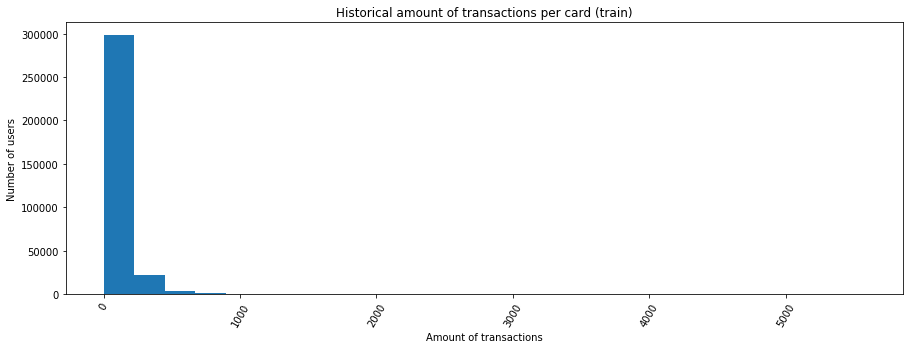

In [16]:
plt.figure(figsize=(15, 5))
plt.hist(df_h['transactions'].values, bins=25)
plt.title('Historical amount of transactions per card (train)')
plt.xlabel('Amount of transactions')
plt.xticks(rotation=60)
plt.ylabel('Number of users')
plt.show()

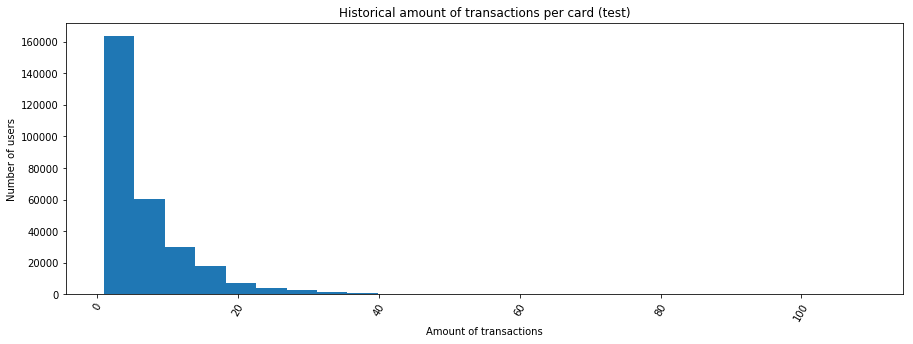

In [15]:
plt.figure(figsize=(15, 5))
plt.hist(df_n['transactions'].values, bins=25)
plt.title('Historical amount of transactions per card (test)')
plt.xlabel('Amount of transactions')
plt.xticks(rotation=60)
plt.ylabel('Number of users')
plt.show()

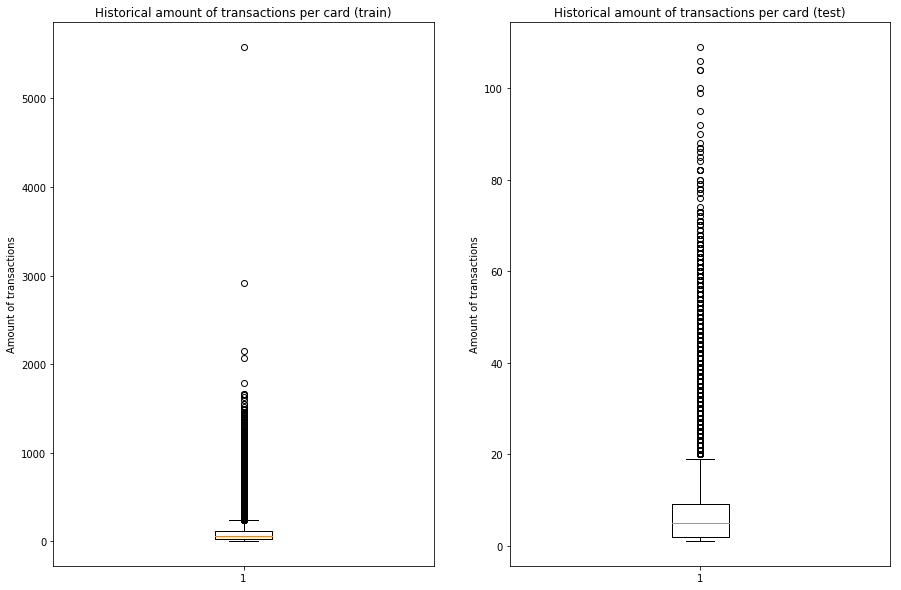

In [25]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.boxplot(df_h['transactions'].values)
plt.title('Historical amount of transactions per card (train)')
plt.ylabel('Amount of transactions')

plt.subplot(1, 2, 2)
plt.boxplot(df_n['transactions'].values)
plt.title('Historical amount of transactions per card (test)')
plt.ylabel('Amount of transactions')
plt.show()

We see that the amounts of transactions in train and test sets do not seem to follow the same distribution. According to the descriptive results, the purchasing dates for both sets are in the same range. However, it could be that, in general, the new transactions correspond to "newer" users which still didn't have time to generate a lot of transactions.
Besides, there are a couple of users in the historical set that may be (even more) outliers.

### Distribution of the amount of transactions over time

In [86]:
def create_date_year_month(df, source_column, preposition):
    df[preposition + '_ym'] = df[source_column].dt.strftime('%Y') + '-' + df[source_column].dt.strftime('%m')    
    return df

In [ ]:
df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_year_month(df_hist_trans, 'purchase_date', 'purchase')

In [87]:
df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_year_month(df_new_trans, 'purchase_date', 'purchase')

In [89]:
df_new_trans.head(3)

KeyboardInterrupt: 

In [74]:
df_h_ym = df_hist_trans.groupby('purchase_ym').size().reset_index().rename({0:'transactions'}, axis=1)

In [90]:
df_n_ym = df_new_trans.groupby('purchase_ym').size().reset_index().rename({0:'transactions'}, axis=1)

Text(0, 0.5, 'Amount of transactions')

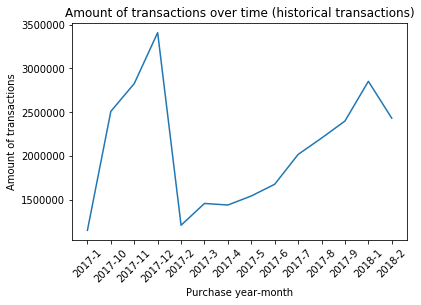

In [75]:
ax = sns.lineplot(x=df_h_ym['purchase_ym'], y=df_h_ym['transactions'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Amount of transactions over time (historical transactions)')
ax.set_xlabel('Purchase year-month')
ax.set_ylabel('Amount of transactions')
ax.xlim('2017-01', '2018-04')

Text(0, 0.5, 'Amount of transactions')

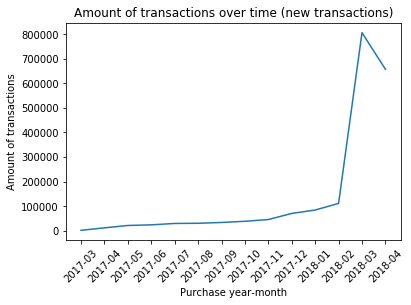

In [95]:
ax = sns.lineplot(x=df_n_ym['purchase_ym'], y=df_n_ym['transactions'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_xlim('2017-01', '2018-04')
ax.set_title('Amount of transactions over time (new transactions)')
ax.set_xlabel('Purchase year-month')
ax.set_ylabel('Amount of transactions')